In [1]:
import os
import warnings
warnings.simplefilter("ignore")

from collections import Counter
from tqdm.notebook import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from utils.text_preprocessing import preprocessing, replace_repetitions


%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
DATA_PATH = 'data/'

os.listdir(DATA_PATH)

['jigsaw-toxic-comment-train.csv',
 'jigsaw-toxic-comment-train_lang.csv',
 'jigsaw-unintended-bias-train.csv',
 'kaggle',
 'sample_submission.csv',
 'test.csv',
 'test_labels.csv',
 'validation.csv']

In [3]:
test = pd.read_csv(DATA_PATH + 'test.csv')
print(test.shape)
test.head(2)

(63812, 3)


,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru


In [4]:
test.lang.value_counts()

tr    14000
pt    11012
ru    10948
fr    10920
it     8494
es     8438
Name: lang, dtype: int64

In [5]:
valid = pd.read_csv(DATA_PATH + 'validation.csv')
print(valid.shape)
valid.head(2)

(8000, 4)


,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0


In [6]:
valid.lang.value_counts()

tr    3000
es    2500
it    2500
Name: lang, dtype: int64

# Explain train data

In [7]:
if 'jigsaw-toxic-comment-train_lang.csv' in os.listdir(DATA_PATH):
    train = pd.read_csv(DATA_PATH + 'jigsaw-toxic-comment-train_lang.csv')
    train.drop('Unnamed: 0', axis=1, inplace=True)
else:
    train = pd.read_csv(DATA_PATH + 'jigsaw-toxic-comment-train.csv')
    
print(train.shape)
train.head(2)

(223549, 9)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lang
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,English
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,English


In [8]:
# from polyglot.detect import Detector

# def get_language(text):
#     return Detector("".join(x for x in text if x.isprintable()), quiet=True).languages[0].name

# train["lang"] = train["comment_text"].progress_apply(get_language)

In [10]:
# Удалим языки, которые встречаются очень редко
# languages = train.lang.value_counts()
# languages = languages[languages > 50]

# train = train[train.lang.isin(languages.index.tolist())]

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
 8   lang           223549 non-null  object
dtypes: int64(6), object(3)
memory usage: 15.4+ MB


In [11]:
# Предобработаем текст
train['text'] = train['comment_text'].progress_apply(preprocessing)
# Посчитаем частоту встречаемости слов
vocab = Counter(' '.join(train['text']).split())
# Преобразуем слова, где есть множественное повторение букв аааавто => авто
train['text'] = train['text'].progress_apply(lambda x: replace_repetitions(x, vocab))

  0%|          | 0/223549 [00:00<?, ?it/s]

  0%|          | 0/223549 [00:00<?, ?it/s]

In [12]:
train = train[train['text'] != '']

(-0.5, 3999.5, 1999.5, -0.5)

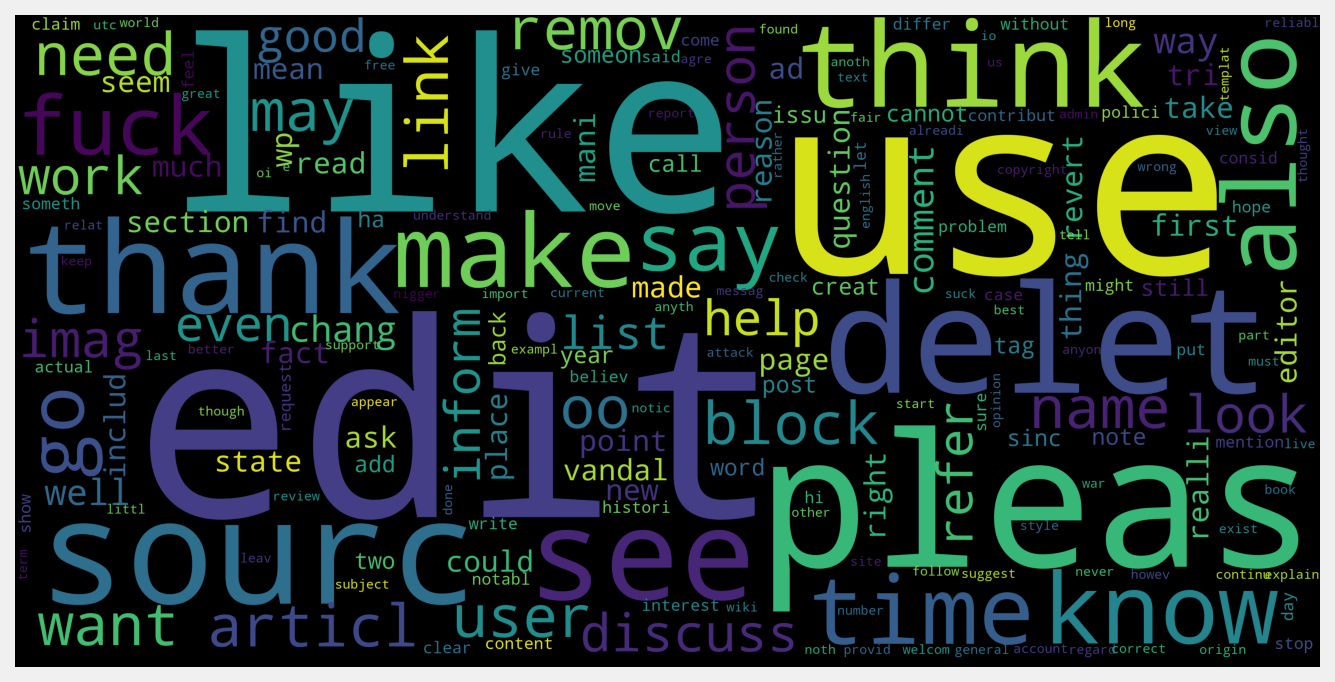

In [13]:
plt.figure(figsize=(10,10), dpi=150)
wc = WordCloud(scale=10).generate_from_frequencies(vocab)

plt.imshow(wc)
plt.axis('off')

In [14]:
# добавим слова с максимальной частотой в stop_words
vocab.most_common(10)

[('edit', 54342),
 ('use', 48228),
 ('like', 42257),
 ('pleas', 40079),
 ('delet', 35223),
 ('sourc', 33086),
 ('thank', 31891),
 ('see', 31076),
 ('think', 30681),
 ('make', 28450)]

In [15]:
train['target'] = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)

(-0.5, 3999.5, 1999.5, -0.5)

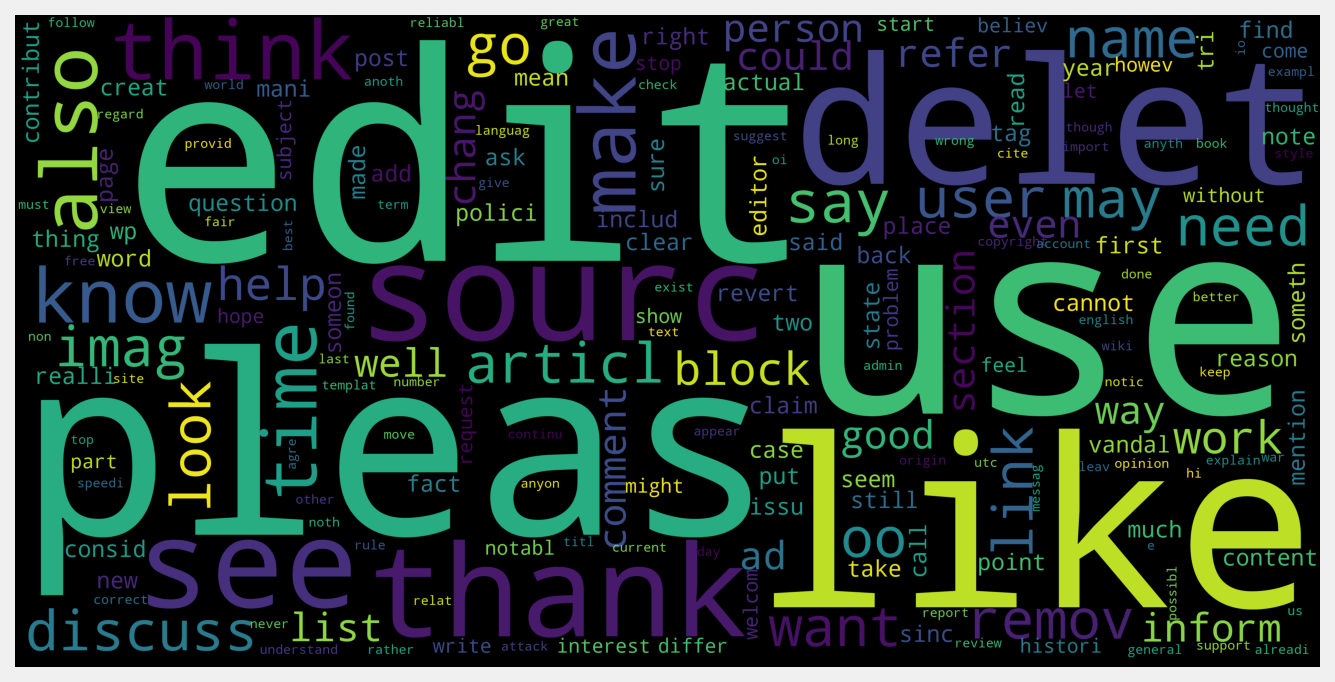

In [21]:
# Посмотрим какие слова часто встречаются в не токсичных предложениях
plt.figure(figsize=(10,10), dpi=150)
vocab = Counter(' '.join(train.query('target == 0')['text']).split())
wc = WordCloud(scale=10).generate_from_frequencies(vocab)

plt.imshow(wc)
plt.axis('off')

(-0.5, 3999.5, 1999.5, -0.5)

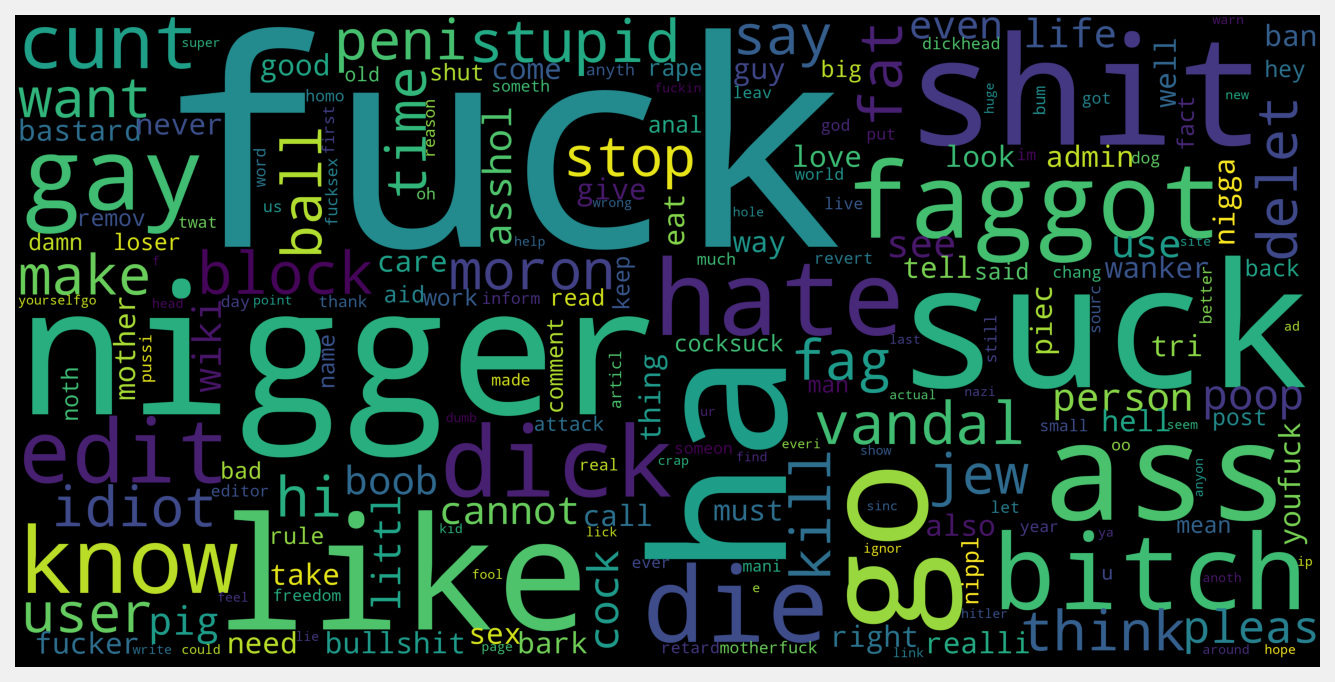

In [22]:
# Посмотрим какие слова часто встречаются в токсичных предложениях
plt.figure(figsize=(10,10), dpi=150)
vocab = Counter(' '.join(train.query('target == 1')['text']).split())
wc = WordCloud(scale=10).generate_from_frequencies(vocab)

plt.imshow(wc)
plt.axis('off')

In [16]:
train['text_len'] = train.text.apply(lambda x: len(x.split()))
train['text_len'].value_counts(bins=10)

(-0.667, 167.6]     217306
(167.6, 334.2]        4212
(334.2, 500.8]        1295
(500.8, 667.4]         111
(667.4, 834.0]          53
(834.0, 1000.6]         18
(1167.2, 1333.8]         8
(1000.6, 1167.2]         7
(1500.4, 1667.0]         3
(1333.8, 1500.4]         0
Name: text_len, dtype: int64

In [17]:
train[train['text_len'] == 2]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lang,text,target,text_len
89,0037fe4f8f5cdcfb,Thanks reading there now !,0,0,0,0,0,0,English,thank read,0,2
138,0057e30091cf3e81,"""\n\n A cookie for you! \n\n A cookie for you...",0,0,0,0,0,0,English,cooki cooki,0,2
177,006ca45465868e64,"86.29.244.57|86.29.244.57]] 04:21, 14 May 2007",0,0,0,0,0,0,English,may oo,0,2
247,009d0fe5e7ee720a,", and I would like to clamp down on them",0,0,0,0,0,0,English,like clamp,0,2
259,00a656a81c6f0903,Y r we doing this: Pat,0,0,0,0,0,0,English,r pat,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
223328,ff130013a8f92464,:Fucking right,1,0,1,0,0,0,un,fuck right,1,2
223348,ff248549b1505bda,== Thanks == \n\n For the clean-up.,0,0,0,0,0,0,English,thank clean,0,2
223388,ff511147e939b9b6,:::You can use https://tools.wmflabs.org/citat...,0,0,0,0,0,0,English,use investig,0,2
223403,ff5c6ac27b9d065b,"""How can it have """"alumni""""? It's not a school...",0,0,0,0,0,0,English,alumni school,0,2


Text(0.5, 0, 'Num words in text')

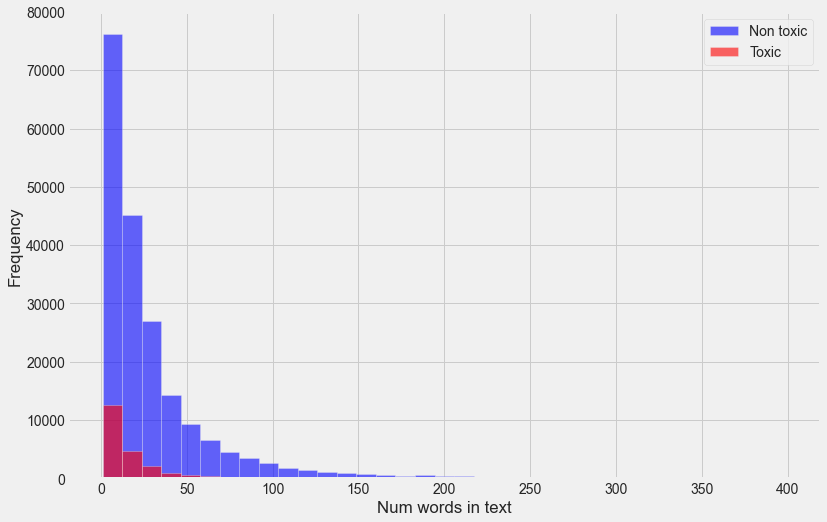

In [18]:
plt.figure(figsize=(12, 8))

train[train.text_len < 400][train.target == 0].text_len.plot(
    bins=35, kind='hist', color='blue', label='Non toxic', alpha=0.6
)
train[train.text_len < 400][train.target == 1].text_len.plot(
    bins=35, kind='hist', color='red', label='Toxic', alpha=0.6
)
plt.legend()
plt.xlabel("Num words in text")

# Explain Train Bias data

In [23]:
train_bias = pd.read_csv(DATA_PATH + 'jigsaw-unintended-bias-train.csv')
print(train_bias.shape)
train_bias.head(2)

(1902194, 45)


,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4


In [24]:
train_bias.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902194 entries, 0 to 1902193
Data columns (total 45 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   id                                   1902194 non-null  int64  
 1   comment_text                         1902194 non-null  object 
 2   toxic                                1902194 non-null  float64
 3   severe_toxicity                      1902194 non-null  float64
 4   obscene                              1902194 non-null  float64
 5   identity_attack                      1902194 non-null  float64
 6   insult                               1902194 non-null  float64
 7   threat                               1902194 non-null  float64
 8   asian                                426707 non-null   float64
 9   atheist                              426707 non-null   float64
 10  bisexual                             426707 non-null   float64
 11

In [25]:
base_columns = ["id", "comment_text", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
intended_columns = ["id", "comment_text", "toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]

# переименуем колонки и удалим лишние
train_bias = train_bias.rename(columns = {x: y for x, y in zip(intended_columns, base_columns)})
train_bias = train_bias[base_columns]

In [26]:
# Предобработаем текст
train_bias['text'] = train_bias['comment_text'].progress_apply(preprocessing)
# Посчитаем частоту встречаемости слов
vocab_bias = Counter(' '.join(train_bias['text']).split())
# Преобразуем слова, где есть множественное повторение букв аааавто => авто
train_bias['text'] = train_bias['text'].progress_apply(lambda x: replace_repetitions(x, vocab_bias))

  0%|          | 0/1902194 [00:00<?, ?it/s]

  0%|          | 0/1902194 [00:00<?, ?it/s]

In [27]:
# удалим пустые тексты
train_bias = train_bias[train_bias['text'] != '']

(-0.5, 3999.5, 1999.5, -0.5)

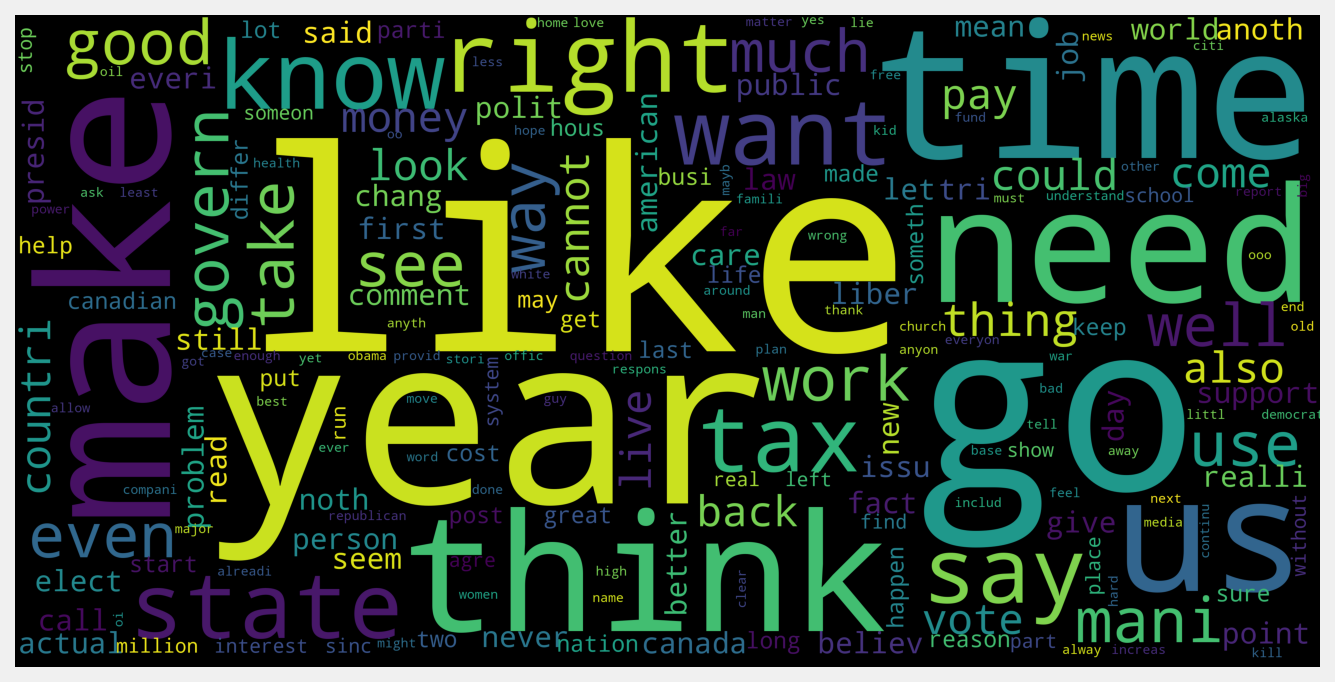

In [28]:
plt.figure(figsize=(10,10), dpi=150)
wc = WordCloud(scale=10).generate_from_frequencies(vocab_bias)

plt.imshow(wc)
plt.axis('off')

In [29]:
vocab_bias.most_common(10)

[('like', 310119),
 ('go', 213629),
 ('year', 213362),
 ('time', 208502),
 ('make', 203660),
 ('think', 189432),
 ('need', 182878),
 ('us', 181409),
 ('right', 178938),
 ('know', 172735)]

In [30]:
# Посмотрим среднюю длину текстов
train_bias['text_len'] = train_bias.text.apply(lambda x: len(x.split()))
train_bias['text_len'].value_counts(bins=10)

(0.588, 42.1]     1520756
(42.1, 83.2]       308051
(83.2, 124.3]       67479
(124.3, 165.4]         40
(165.4, 206.5]          3
(206.5, 247.6]          1
(288.7, 329.8]          1
(370.9, 412.0]          1
(247.6, 288.7]          0
(329.8, 370.9]          0
Name: text_len, dtype: int64

In [31]:
# Посмотрим распределение таргета в выборке train_bias
train_bias.toxic.value_counts(bins=10)

(-0.002, 0.1]    1344159
(0.1, 0.2]        267545
(0.2, 0.3]         66503
(0.3, 0.4]         58512
(0.4, 0.5]         47392
(0.5, 0.6]         36043
(0.6, 0.7]         28273
(0.7, 0.8]         22785
(0.8, 0.9]         17214
(0.9, 1.0]          7906
Name: toxic, dtype: int64

(-0.5, 3999.5, 1999.5, -0.5)

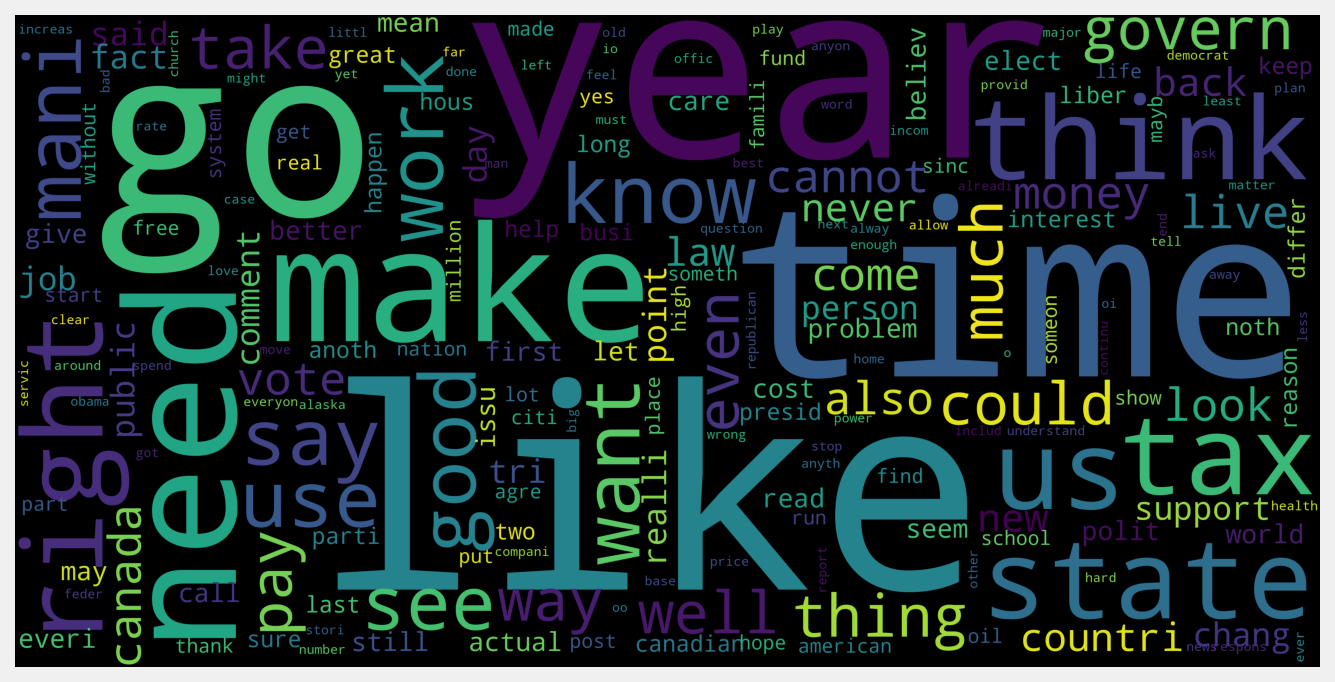

In [34]:
# Посмотрим какие слова часто встречаются в не токсичных предложениях
plt.figure(figsize=(10,10), dpi=150)
vocab_bias = Counter(' '.join(train_bias.query('toxic == 0')['text']).split())
wc = WordCloud(scale=10).generate_from_frequencies(vocab_bias)

plt.imshow(wc)
plt.axis('off')

(-0.5, 3999.5, 1999.5, -0.5)

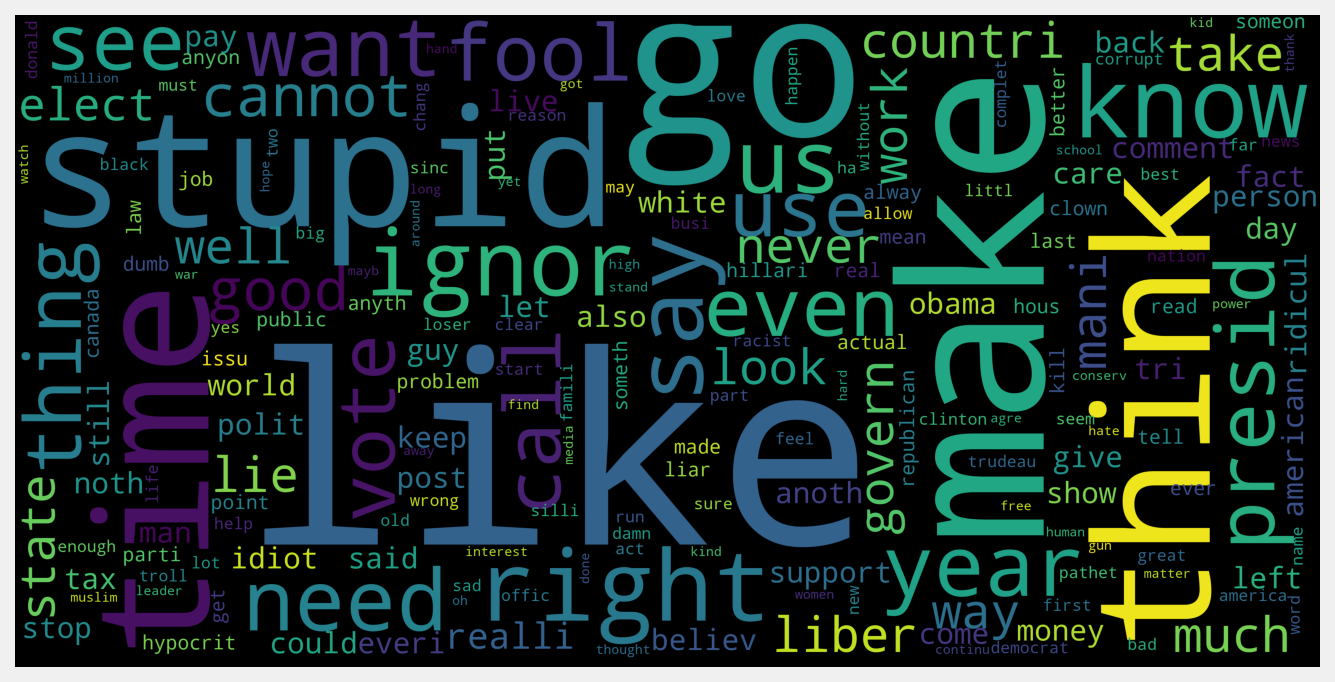

In [35]:
# Посмотрим какие слова часто встречаются в токсичных предложениях
plt.figure(figsize=(10,10), dpi=150)
vocab_bias = Counter(' '.join(train_bias.query('toxic == 1')['text']).split())
wc = WordCloud(scale=10).generate_from_frequencies(vocab_bias)

plt.imshow(wc)
plt.axis('off')

In [38]:
train_bias.query('toxic == 1').comment_text.values

array(['Where do you get the Sour Grapes to say this is a Bernie person?  Based on how Bernie does not allow this crap to go on where do you get off with the accusation?',
       'Dear world:\nJust a reminder that none of these folks actually live in Oregon.  Please remember that when you decide to paint our state as a bunch of wackos! \n\nSincerely,\nOregon',
       'The Liars Anonymous meeting today will be at 4:00. Speaker: Mick Jagger.',
       ...,
       "Any destruction of Alaska's Grand Nature by the oil n gas industry means the industry needs higher standards.  The state needs to be the state (tax, regulate, oversight) and quit trying to be a partner.  Public/private partnerships are stupid.  Good read!",
       "And if an employee cannot live on the offered wage, he/she should get another job. If such employee fails to command a higher wage for the work provided, clearly we're talking about a deficient and failed employee.",
       "Good lord it looks like mr. zipper plat is 